In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [4]:
df_ratio_cpu = pd.read_csv('NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv')

In [5]:
print(df_ratio_cpu.head())
print(df_ratio_cpu.tail())

             timestamp  value
0  2014-02-14 14:30:00  0.132
1  2014-02-14 14:35:00  0.134
2  2014-02-14 14:40:00  0.134
3  2014-02-14 14:45:00  0.134
4  2014-02-14 14:50:00  0.134
                timestamp  value
4027  2014-02-28 14:05:00  0.132
4028  2014-02-28 14:10:00  0.134
4029  2014-02-28 14:15:00  0.134
4030  2014-02-28 14:20:00  0.134
4031  2014-02-28 14:25:00  0.134


In [15]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.savefig('data.png')
    plt.show()

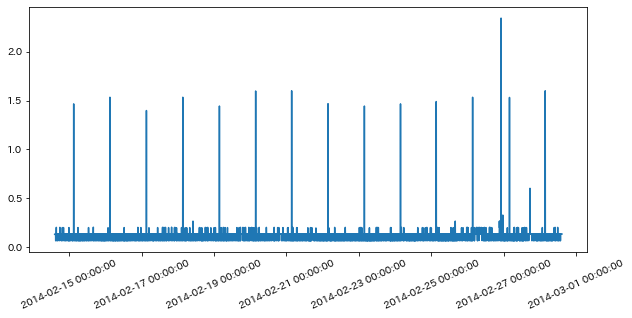

In [16]:
plot_dates_values(df_ratio_cpu)

In [17]:
index_devide =  df_ratio_cpu[df_ratio_cpu["timestamp"]=="2014-02-26 00:00:00"].index[0]

In [18]:
df_small_noise = df_ratio_cpu[:index_devide]
df_daily_jumpsup = df_ratio_cpu[index_devide:]

In [19]:
print(df_small_noise.head())
print(df_small_noise.tail())


             timestamp  value
0  2014-02-14 14:30:00  0.132
1  2014-02-14 14:35:00  0.134
2  2014-02-14 14:40:00  0.134
3  2014-02-14 14:45:00  0.134
4  2014-02-14 14:50:00  0.134
                timestamp  value
3277  2014-02-25 23:35:00  0.134
3278  2014-02-25 23:40:00  0.066
3279  2014-02-25 23:45:00  0.134
3280  2014-02-25 23:50:00  0.134
3281  2014-02-25 23:55:00  0.202


In [20]:
print(df_daily_jumpsup.head())
print(df_daily_jumpsup.tail())

                timestamp  value
3282  2014-02-26 00:00:00  0.066
3283  2014-02-26 00:05:00  0.200
3284  2014-02-26 00:10:00  0.134
3285  2014-02-26 00:15:00  0.066
3286  2014-02-26 00:20:00  0.132
                timestamp  value
4027  2014-02-28 14:05:00  0.132
4028  2014-02-28 14:10:00  0.134
4029  2014-02-28 14:15:00  0.134
4030  2014-02-28 14:20:00  0.134
4031  2014-02-28 14:25:00  0.134


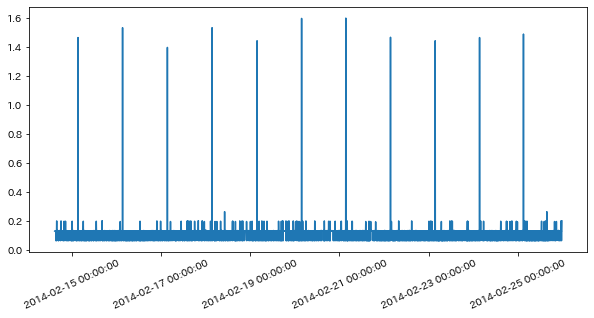

In [21]:
plot_dates_values(df_small_noise)

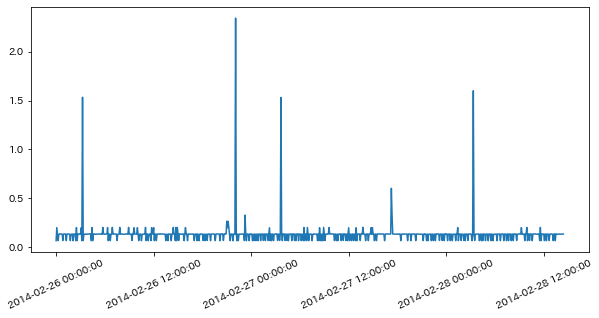

In [22]:
plot_dates_values(df_daily_jumpsup)

In [23]:
def get_value_from_df(df):
    return df.value.to_list()

def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


training_value = get_value_from_df(df_small_noise)

training_value, training_mean, training_std = normalize(training_value)
len(training_value)

3282

In [24]:
TIME_STEPS = 100#12#288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
        
    return np.expand_dims(output, axis=2)

x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3182, 100, 1)


In [25]:
ks = 7
strides = 2

model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))

model.add(layers.Conv1D(filters=32, kernel_size=ks, padding="same", strides=strides, activation="relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv1D(filters=16, kernel_size=ks, padding="same", strides=strides, activation="relu"))
model.add(layers.Conv1DTranspose(filters=16, kernel_size=ks, padding="same", strides=strides, activation="relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv1DTranspose(filters=32, kernel_size=ks, padding="same", strides=strides, activation="relu"))

model.add(layers.Conv1DTranspose(filters=1, kernel_size=ks, padding="same"))

model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 32)            256       
_________________________________________________________________
dropout (Dropout)            (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 100, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 100, 1)            2

In [26]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    #shuffle=False,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")]
)

Epoch 1/100
23/23 [==============================] - 1s 46ms/step - loss: 0.9621 - val_loss: 0.6894
Epoch 2/100
23/23 [==============================] - 1s 32ms/step - loss: 0.5476 - val_loss: 0.2009
Epoch 3/100
23/23 [==============================] - 1s 33ms/step - loss: 0.2356 - val_loss: 0.0873
Epoch 4/100
23/23 [==============================] - 1s 32ms/step - loss: 0.1472 - val_loss: 0.0644
Epoch 5/100
23/23 [==============================] - 1s 33ms/step - loss: 0.1298 - val_loss: 0.0540
Epoch 6/100
23/23 [==============================] - 1s 33ms/step - loss: 0.1113 - val_loss: 0.0477
Epoch 7/100
23/23 [==============================] - 1s 33ms/step - loss: 0.1055 - val_loss: 0.0448
Epoch 8/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0950 - val_loss: 0.0425
Epoch 9/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0897 - val_loss: 0.0388
Epoch 10/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0861 - val_loss: 0.0368

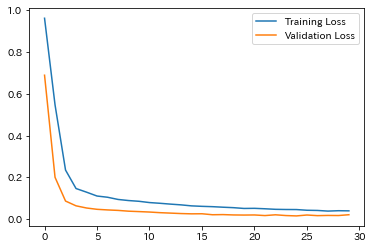

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

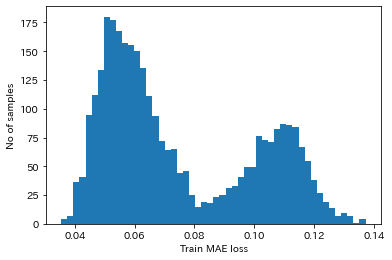

Reconstruction error threshold:  0.13713389659416378


In [28]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

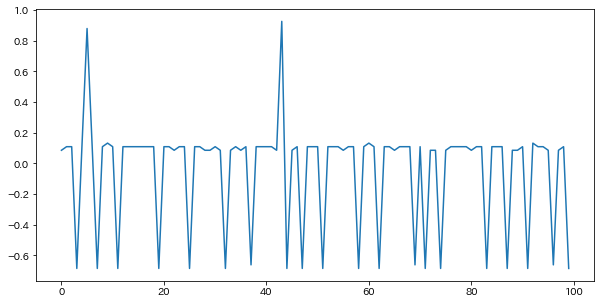

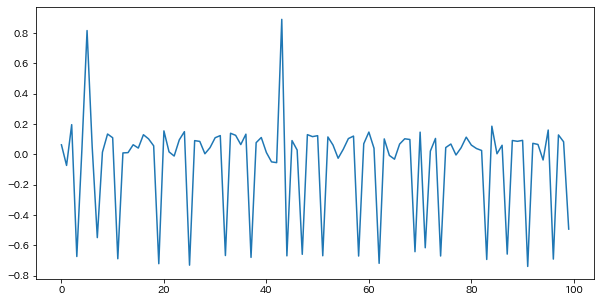

In [35]:
plt.figure(figsize=(10,5))
plt.plot(x_train[264])
plt.savefig('train.png')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x_train_pred[264])
plt.savefig('train_pred.png')
plt.show()

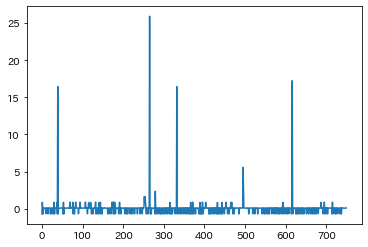

Test input shape:  (650, 100, 1)


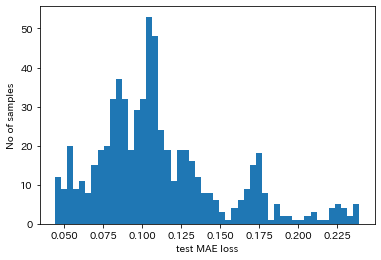

Number of anomaly samples:  127
Indices of anomary samples;  (array([  1,   3,   9,  10,  11,  13,  14,  15,  17,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  33,  36,  37,  38,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 267], dtype=int64),)


In [30]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value)
plt.show()


x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomary samples; ", np.where(anomalies))

In [31]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [32]:
anomalous_data_indices

[265, 266]

ValueError: DateFormatter found a value of x=0, which is an illegal date; this usually occurs because you have not informed the axis that it is plotting dates, e.g., with ax.xaxis_date()

<Figure size 432x288 with 1 Axes>

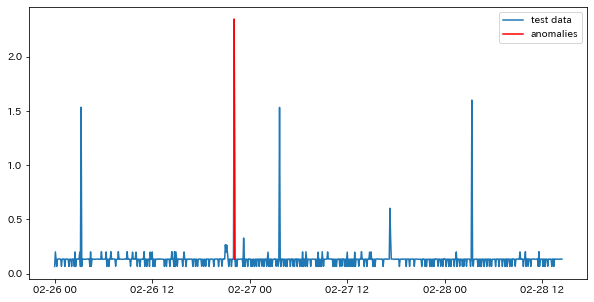

In [33]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.figure(figsize=(10,5))
plt.plot(dates, values, label="test data")


dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.savefig('data_detected.png')
plt.show()

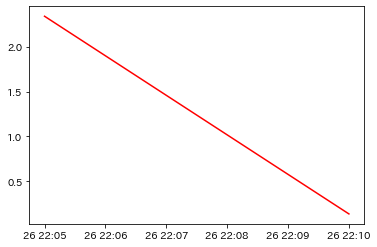

In [34]:
dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

In [216]:
dates

[]